# Predicting the Likelihood of Heart Disease based on Age, Cholesterol and ST Depression of an Individual 

#### Lisa Li, Jovan Kannitho, Justin An, Tammy Ou

## Introduction

Heart disease or Cardiovascular disease is a type of disease that affects the heart or blood vessels. According to the 2024 Heart Disease and Stroke Statistics: A Report of U.S. and Global Data From the American Heart Association, heart disease has been the leading cause of death in the U.S. for nearly 100 years. The risk of certain heart diseases may be increased by smoking, high blood pressure, high cholesterol, unhealthy diet, lack of exercise, and obesity (NCI Dictionary of Cancer Terms, n.d.).  With such importance, identifying consistent predictors for heart disease is crucial.

For our analysis, we consider seldom analyzed data from the Heart Disease Dataset (Janosi et al., 1988), specifically the VA Long Beach Dataset. While 76 attributes complete the dataset, only 14 are used attributes are used in publications due to their predictive relevance. We aim to apply the knn-classification algorithm to this dataset to answer the questi: **Based on age, Cholesterol and ST Depression, can we predict whether an individual will develop heart disee?** **


In [1]:
install.packages("psych")
install.packages("ggcorrplot")
library(tidyverse)
library(tidymodels)
library(dplyr)
library(RColorBrewer)
library(kknn)
library(psych)
library(ggcorrplot)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     

### Loading and Cleaning Data

In [2]:
#reading data and changing names of the columns
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data"
column_names <- c("age",
                  "sex",
                  "chest_pain",
                  "resting_bp",
                  "cholesterol", 
                  "fasting_bp",
                  "resting_ecg",
                  "max_hrate_achieved",
                  "exercise_induced_angina",
                  "st_depression",
                  "slope",
                  "major_vessels",
                  "thalassemia", # too much iron in blood
                  "diagnosis_num") # changed from num to diagnonsis_num


va_heart_data <- read_csv(url,
                    col_names = c(column_names),
                    col_types = list("d", "f", "f", "d", "d", "f", "f", "d", "f", "d", "f", "i", "f", "d")) 

# changed diagnosis levels of 0-4 to True and False 
# if True -> presence of heart disease (original values 1-4) , False -> absence of heart disease (original value of 0)
va_heart_data_clean <- va_heart_data |>
    mutate(diagnosis = diagnosis_num > 0) 
    
                                  
#changing all unknown values (?) to NA values
# va_heart_data_clean[va_heart_data_clean == "?"] <- NA

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


### Cleaning Dataset

In [3]:
# Omiting columns which have mostly NA values
va_heart_data_clean <- va_heart_data_clean |>
    select(-thalassemia,-major_vessels)

# Omiting rows which have NA values
va_heart_data_clean <- va_heart_data_clean |>
  mutate(across(everything(), ~ifelse(. == "?", NA, .))) |>
  na.omit()


### Training and Testing Sets, and Exploratory Data Analysis

We split our data set into training (75%) and testing (25%) sets. A seed was used to ensure reproducibility.


In [4]:
set.seed(1)
va_split <- initial_split(va_heart_data_clean, prop = .75, strata = diagnosis)
va_train <- training(va_split)
va_test <- testing(va_split)

In [5]:
#split our va_train_select into two dataframes: one with our numeric (num) variables, and one with our categorical (cat) variables

va_train_numeric <- va_train |>
                        select(age, resting_bp, cholesterol, max_hrate_achieved, st_depression, diagnosis)

va_train_categoric <- va_train |>
                        select(sex, chest_pain, fasting_bp, resting_ecg, exercise_induced_angina, slope, diagnosis)


A correlation matrix will help identify variables with the highest impact on heart disease. We use numeric variables, which are ideal with the correlational matrix and knn-algorithm. We retain the categorical variables for future use in visualizations. 

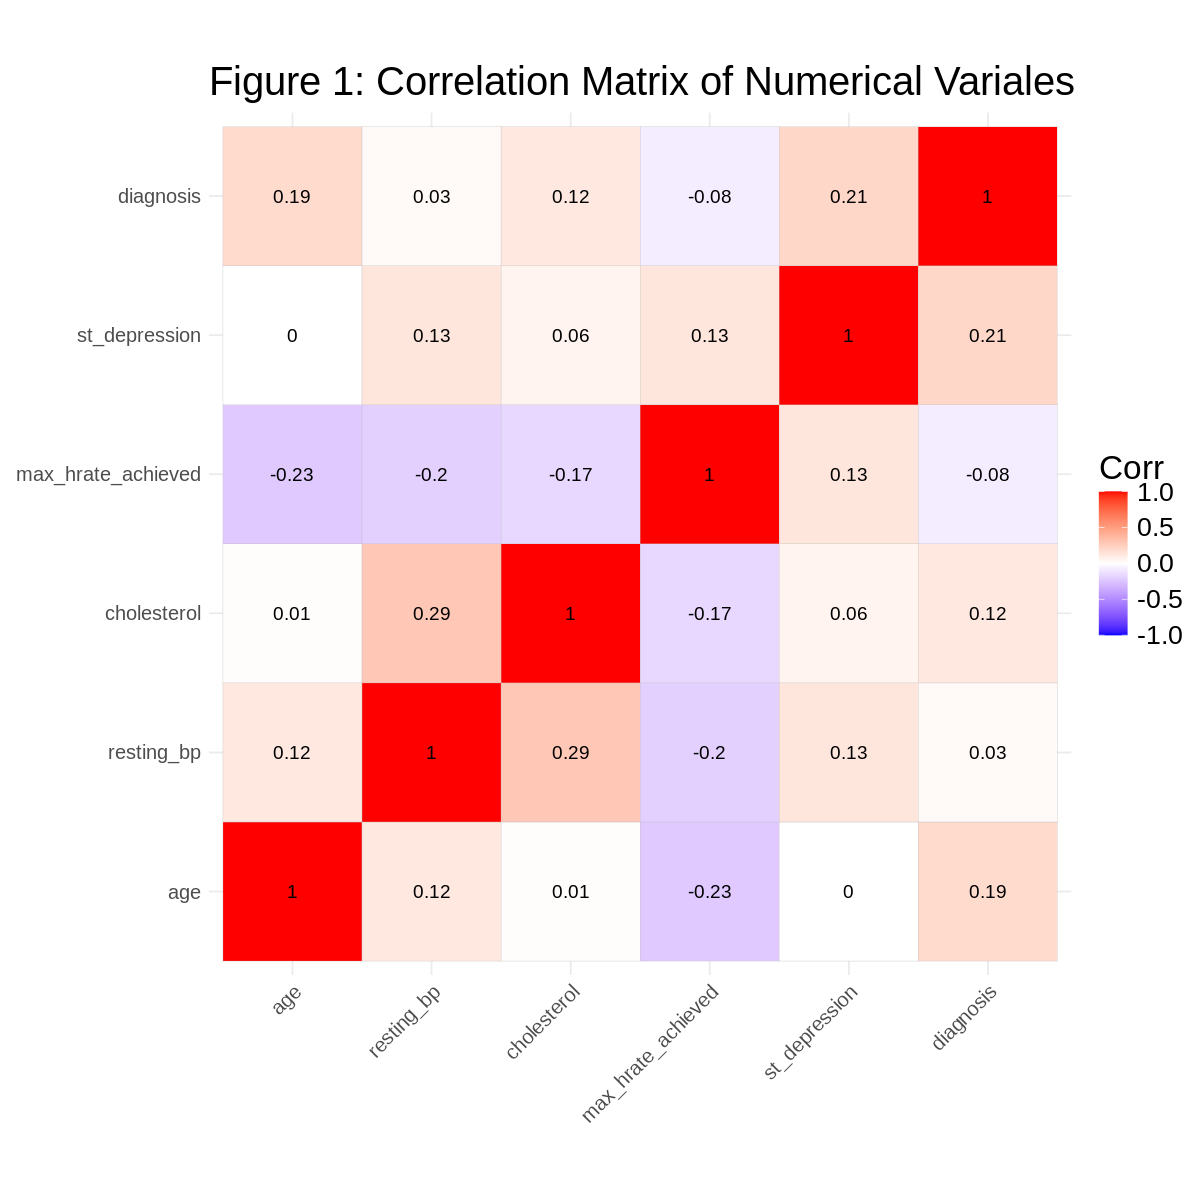

In [6]:
#making a correlation matrix of data using cor()
options(repr.plot.width = 10, repr.plot.height = 10)
correlation_matrix <- cor(va_train_numeric)

#creating a plot of the results 
ggcorrplot(correlation_matrix, lab = TRUE) + 
    labs(title = "Figure 1: Correlation Matrix of Numerical Variales") + 
    theme(text = element_text(size = 20))


We choose  st_depression, age and cholesterol as our predictor variables, as they have the highest correlations with the outcome variable, and we will further explore them below.  

In [7]:
#selecting the 3 variables with the highest correlation to heart disease as determined by the correlation matrix
#renamed columns to increase clarity
va_heart_data_top_3 <-select(va_train_numeric, "diagnosis", "st_depression","age", "cholesterol")


In [8]:
#summarize each predictor using mean and standard deviation, grouped by diagnosis 

summary_st_depression <- va_heart_data_top_3 |>
         group_by(diagnosis) |>
         summarize(mean_st_depression = mean(st_depression),
                   sd_st_depression = sd(st_depression))

summary_age <- va_heart_data_top_3 |>
         group_by(diagnosis) |>
         summarize(mean_age = mean(age), sd_age = sd(age)) 



summary_cholesterol <- va_heart_data_top_3 |>
         group_by(diagnosis) |>
         summarize(mean_cholesterol = mean(cholesterol),sd_cholesterol = sd(cholesterol))



summary_st_depression
summary_age
summary_cholesterol



diagnosis,mean_st_depression,sd_st_depression
<lgl>,<dbl>,<dbl>
FALSE,1.345455,0.8959505
TRUE,1.896296,0.9792109


diagnosis,mean_age,sd_age
<lgl>,<dbl>,<dbl>
FALSE,57.90909,9.761706
TRUE,61.14815,5.557274


diagnosis,mean_cholesterol,sd_cholesterol
<lgl>,<dbl>,<dbl>
FALSE,143.5455,154.9583
TRUE,181.0741,115.8196


We observe higher means for st_depression, age and cholesterol for individuals who have heart disease. Variability is comparable across diagnosis groups for age and st depression, except for cholesterol.

### Visualization of Data

We created histograms to visualize the distributions of the predictor variables and split the comparison by diagnosis. 


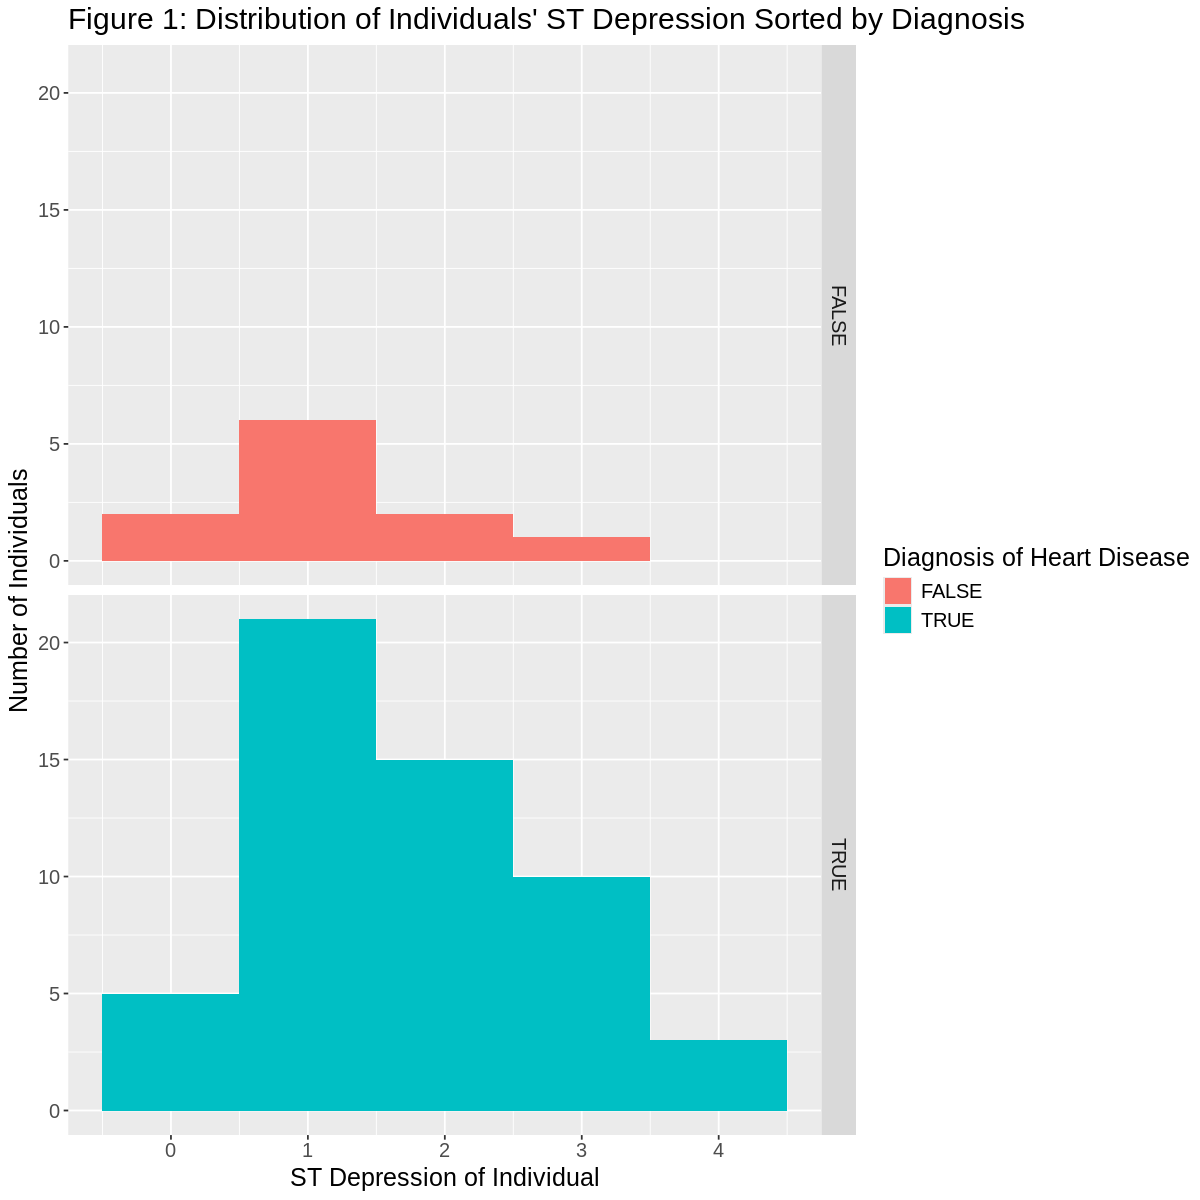

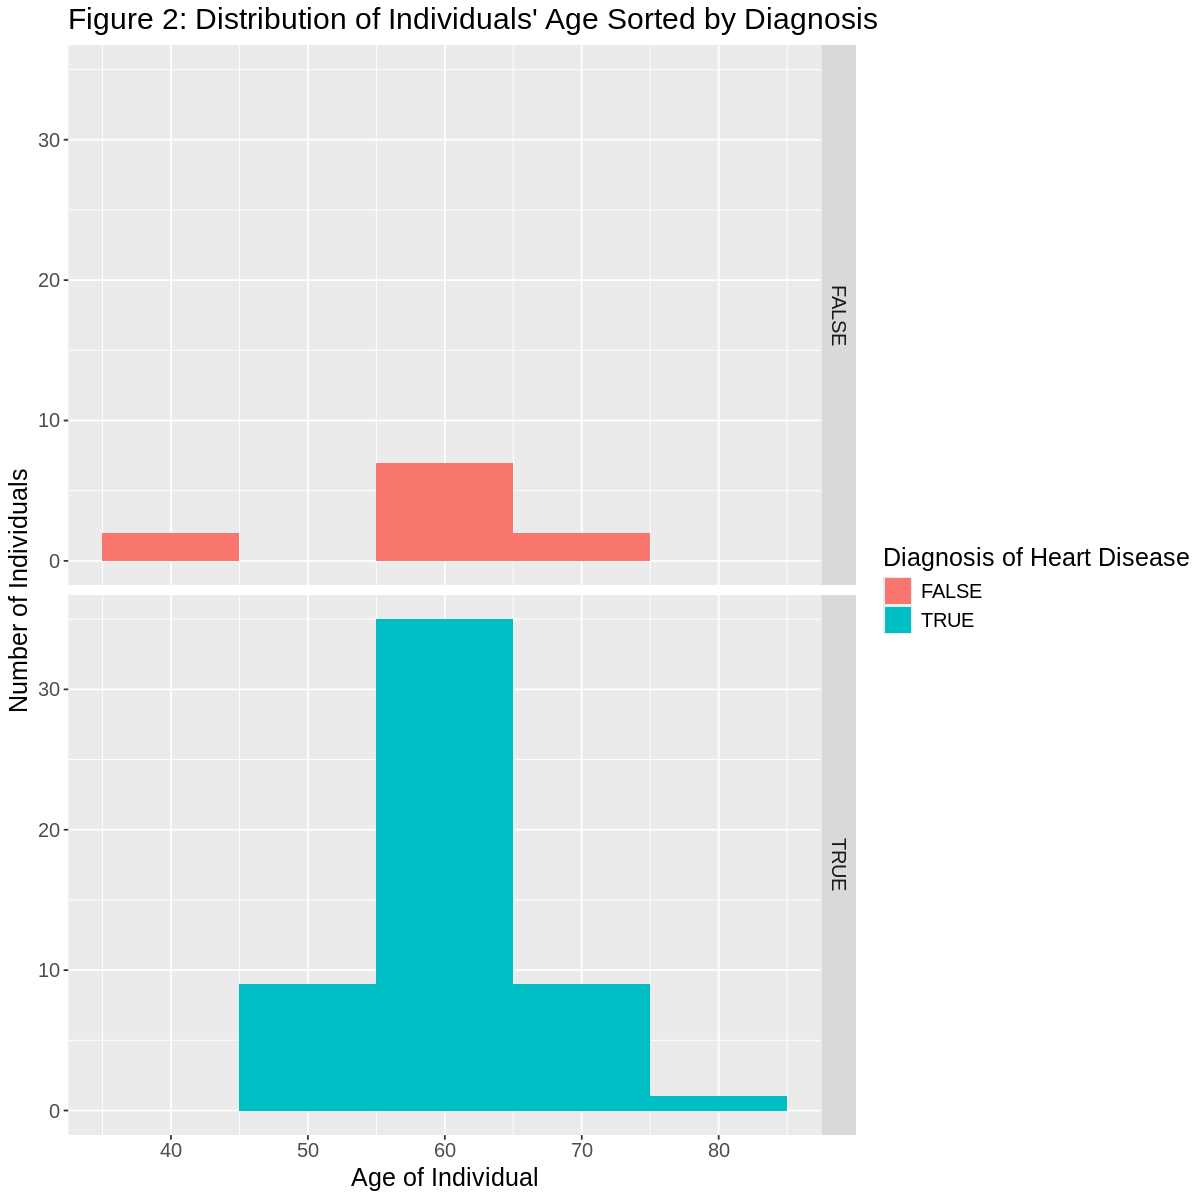

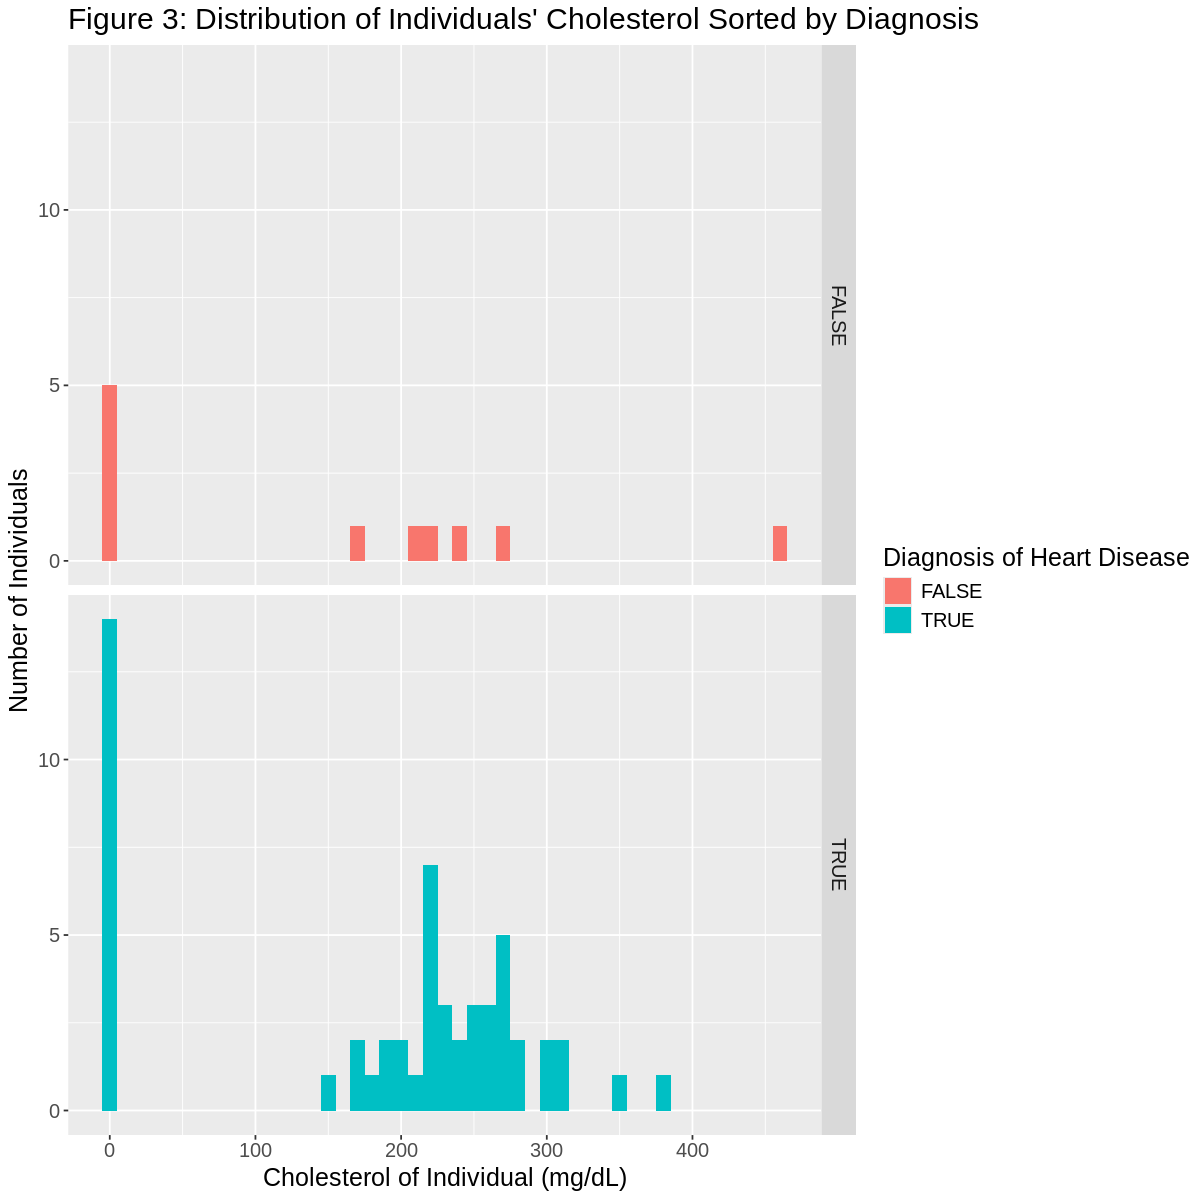

In [9]:
options(repr.plot.width = 10, repr.plot.height = 10)


st_depression_plot <- va_train_numeric |>
                       select(diagnosis, st_depression) |>
                        ggplot(aes(x = st_depression, fill=diagnosis)) +
                        geom_histogram(binwidth=1) +
                        facet_grid(rows = vars(diagnosis)) + 
                        labs (x = "ST Depression of Individual",
                              y = "Number of Individuals", 
                              fill = "Diagnosis of Heart Disease",
                              title = "Figure 1: Distribution of Individuals' ST Depression Sorted by Diagnosis") + 
                              theme(text = element_text(size = 15))
                              

age_plot <- va_train_numeric |>
                       select(diagnosis, age) |>
                        ggplot(aes(x = age, fill=diagnosis)) +
                        geom_histogram(binwidth =10) +
                        facet_grid(rows = vars(diagnosis)) +
                        labs (x = "Age of Individual",
                              y = "Number of Individuals", 
                              fill = "Diagnosis of Heart Disease", 
                              title = "Figure 2: Distribution of Individuals' Age Sorted by Diagnosis") + 
                        theme(text = element_text(size = 15))

cholesterol_plot <- va_train_numeric |>
                       select(diagnosis, cholesterol) |>
                        ggplot(aes(x = cholesterol, fill=diagnosis)) +
                        geom_histogram(binwidth =10) +
                        facet_grid(rows = vars(diagnosis)) +
                        labs (x = "Cholesterol of Individual (mg/dL)",
                              y = "Number of Individuals", 
                              fill = "Diagnosis of Heart Disease",
                              title = "Figure 3: Distribution of Individuals' Cholesterol Sorted by Diagnosis") + 
                        theme(text = element_text(size = 15))

st_depression_plot
age_plot
cholesterol_plot


The graphs above show that values for individuals with heart disease tend to be in the higher end of the distribution compared to those without heart disease (for all predictor variables). 

Lastly, as the knn-classification model uses interactions between variables to predict outcomes, we used a scatterplot to explore interactions between age and Cholesterol levels. 


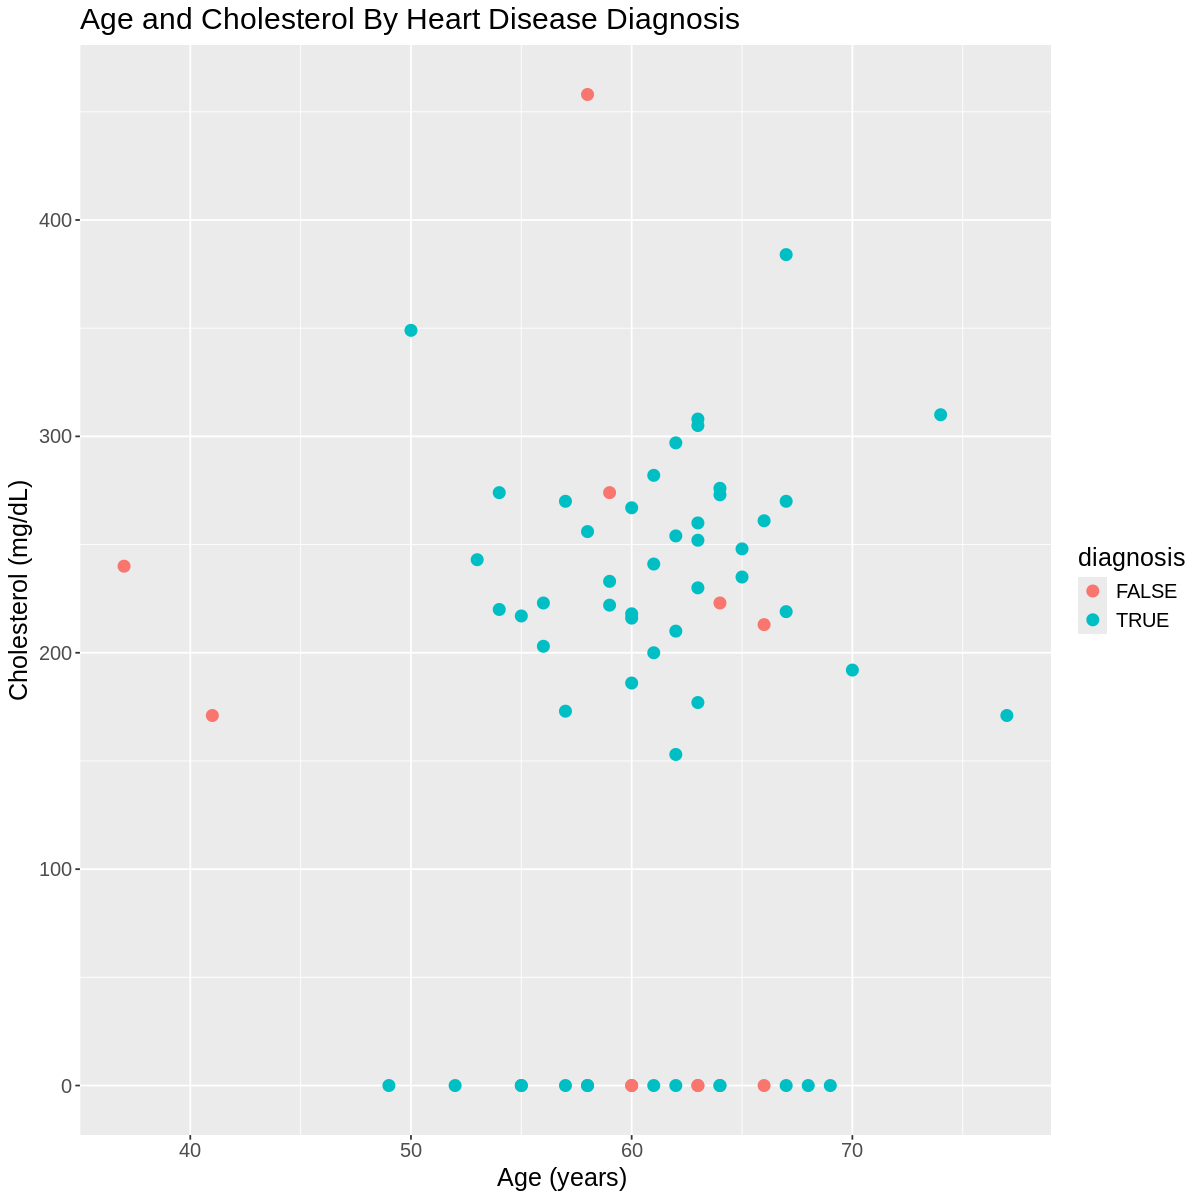

In [10]:
age_and_cholesterol_plot <- va_heart_data_top_3 |>
                           ggplot(aes(x = age, y = cholesterol, color = diagnosis)) +
                           geom_point(size = 3) +
                           labs( x= "Age (years) ", y = "Cholesterol (mg/dL)") +
                           ggtitle("Age and Cholesterol By Heart Disease Diagnosis") +
                           theme(text = element_text(size = 15))

age_and_cholesterol_plot

The presence of heart disease is more likely at higher values of age and Cholesterol. 


## Methods

1.  Read and transform data into tidy format.

2. Create knn-classification algorithm using chosen predictors.

3. Cross-validation to determine optimal k-value for accuracy.

4. Use test data and check accuracy.

5. Visualize predictor interactions and the predicted outcome, using above k-value and scatterplots. Further explore patterns with the categorical variables. 




## Expected Outcomes and Significance


 **Expected** **Outcomes**

Based on our preliminary explorations, we expect that higher values for age, Cholesterol, and ST depression will predict the presence of heart disease.

It is important to note that most of our exploration has been done on isolating one variable and its relation to the outcome. As the knn-model uses interactions between variables, different patterns from our initial exploration may emerge.

*Implications*

Using VA Long Beach data may indicate if results of studies using Cleveland data can generalize to other locations. If true, it can add confidence to the predictive power of the variables. Divergent findings may prompt future research into why such predictors appeared irrelevant for VA Long beach, and if exploration beyond the subset of 14 attributes is needed.


## Tuning K-NN Model

In [11]:
#changing diagnosis to a factor 
va_train <- va_train |>
    mutate(diagnosis = as_factor(diagnosis))


knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

#creating classification recipe
heart_recipe <- recipe(diagnosis ~ cholesterol + st_depression + age, data = va_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#5 fold cross-validation 

heart_vfold <- vfold_cv(va_train, v = 5, strata = diagnosis)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 5))

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |> 
    tune_grid(resamples = heart_vfold, grid = k_vals)

heart_results <- heart_fit |>
    collect_metrics()

accuracies <- heart_results |>
    filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8148352,5,0.03148692,Preprocessor1_Model01
6,accuracy,binary,0.8161172,5,0.01616086,Preprocessor1_Model02
11,accuracy,binary,0.8315018,5,0.01171302,Preprocessor1_Model03
16,accuracy,binary,0.8315018,5,0.01171302,Preprocessor1_Model04
21,accuracy,binary,0.8315018,5,0.01171302,Preprocessor1_Model05
26,accuracy,binary,0.8315018,5,0.01171302,Preprocessor1_Model06
31,accuracy,binary,0.8315018,5,0.01171302,Preprocessor1_Model07
36,accuracy,binary,0.8315018,5,0.01171302,Preprocessor1_Model08
41,accuracy,binary,0.8315018,5,0.01171302,Preprocessor1_Model09


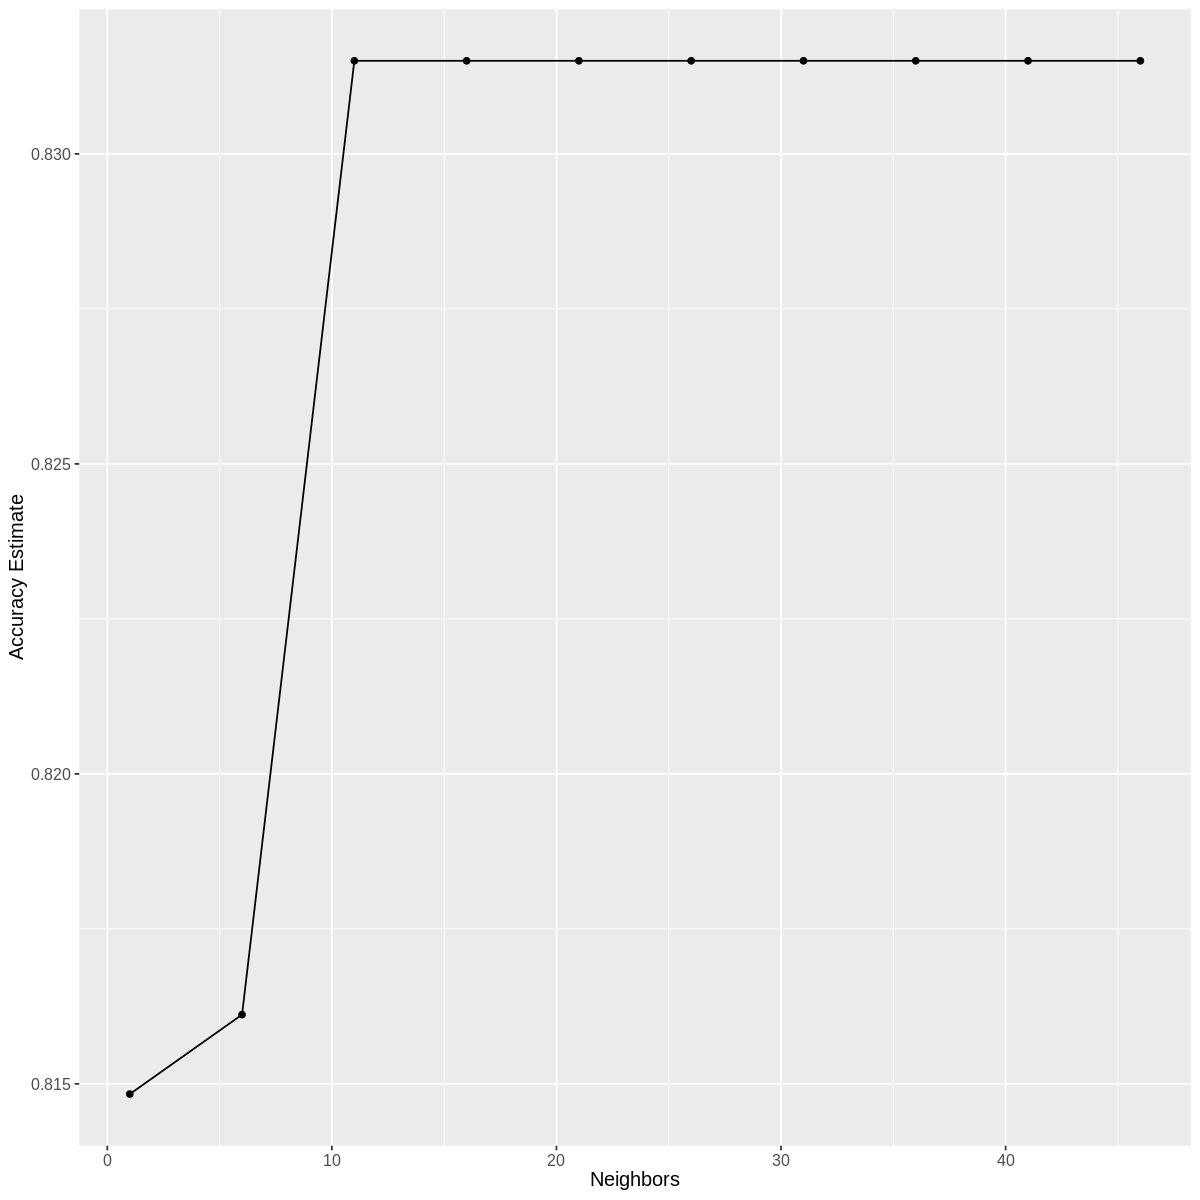

In [12]:
# visualizing the accuracy vs K plot

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

In [13]:
#determining the best k value
best_k_value <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k_value

[1] 11

## Testing: Classification Model with Optimal K

In [14]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |> 
    fit(data = va_train)


#using model to predict the testing data
validation_predicted <- predict(heart_fit, va_test) |>
    bind_cols(va_test)

#changing diagnosis to a factor in binded dataset
validation_predicted <- validation_predicted |>
    mutate(diagnosis = as_factor(diagnosis))

#determining the accuracy of the model
accuracy <- validation_predicted |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

accuracy

[1] 0.8181818

In [15]:
# predicted_vs_actual <- validation_predicted |>
#                         select(.pred_class, diagnosis)

va_test

age,sex,chest_pain,resting_bp,cholesterol,fasting_bp,resting_ecg,max_hrate_achieved,exercise_induced_angina,st_depression,slope,diagnosis_num,diagnosis
<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<lgl>
55,1,1,142,228,1,1,149,1,2.5,4,1,TRUE
59,1,1,140,0,1,1,117,1,1.0,1,1,TRUE
46,1,1,110,236,1,3,125,1,2.0,1,1,TRUE
56,1,1,120,100,1,3,120,1,1.5,1,1,TRUE
52,1,2,122,0,1,3,110,1,2.0,3,2,TRUE
56,1,3,124,224,2,3,161,2,2.0,1,0,FALSE
58,1,3,126,0,2,3,110,1,2.0,1,2,TRUE
57,1,1,140,214,1,1,144,1,2.0,1,2,TRUE
72,1,2,120,214,1,3,102,1,1.0,1,3,TRUE


## Confusion Matrix

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE      4   18

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


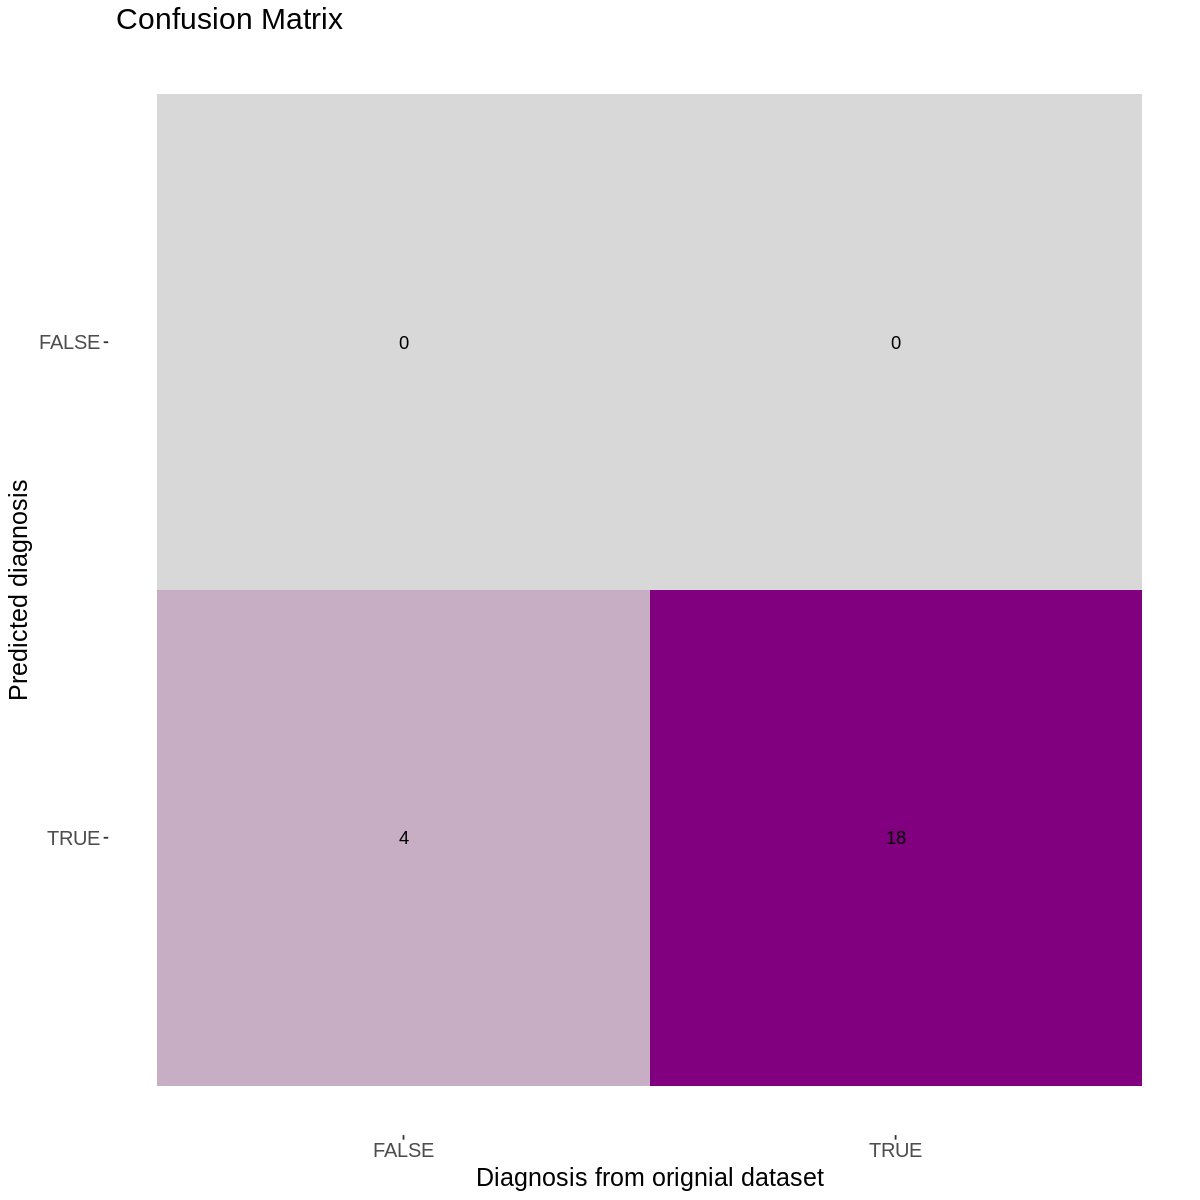

In [16]:
#creating the confusion matrix dataframe
heart_confusion_df <- validation_predicted |>
    conf_mat(truth = diagnosis, estimate = .pred_class)

heart_confusion_df
     
#creating the visualization of the df

heart_confusion_visual <- heart_confusion_df |>
    autoplot(type = "heatmap") +
    labs(x = "Diagnosis from orignial dataset",
         y = "Predicted diagnosis",
         title = " Confusion Matrix") +
    scale_fill_gradient(low = "#d8d8d8", high = "#800080") +
    theme(text = element_text(size = 15))
heart_confusion_visual
     

## Discussion

The 81% accuracy of the classification model with the optimal k value of 11 indicates that the set of predictors (cholesterol, st depression and age) are strong predictors of heart disease. In addition, the confusion matrix also summarizes that there are 4 false positives and 18 correct diagnoses made by the classification model out of the 22 observations in the testing data set. The classifier has a precision of ~81% and a recall of 100%. As undiagnosed heart disease can lead to detrimental consequences, maximizing recall should be a priority, which is demonstrated by the classifier.  

The findings align with our expected outcomes that higher values of age, cholesterol and st depression will predict the presence of heart disease. However, as previous exploratory analysis mainly looked at the relationship between an individual predictor and the presence of heart disease, and as these relationships all had relatively weak correlations (st_depression and diagnosis r=.21, age and diagnosis r = .19,  cholesterol and diagnosis r=.21), we did not expect that that the set of predictors would have resulted in an accuracy of 81%.

These findings have several real world research and practical applications. First, as the results show that the set of predictors resulted in more accurate and stronger predictors together than when explored individually, this highlights that there may be significant interactions between the predictors of cholesterol, st depression and age. Future research should first attempt to explore if these findings replicate in order to validate the results of this analysis. As the sample size of our testing set was relatively small (n=22), larger samples should also be used if possible. If consistent patterns are found, future research can also look into delineating the specific interactions between the three predictors, and to study the underlying mechanisms driving these interactions. For practical applications, clinicians should approach assessment and treatment in an integrated manner, by reducing the potential harmful interactions between the predictors, rather than only treating the predictors in an isolated manner. Similarly, public health programs can also seek to reduce the risks of heart disease on a population level using the same approach. 



## References